. <h1 style='text-align: center;'> Hotel Booking Analysis </h1>

## **Importing Libraries**

In [100]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import io
%matplotlib inline
sns.set_style('whitegrid')

In [101]:
data = pd.read_csv('C:\\Users\mubas\Downloads\hotel_bookings.csv')
data.head()
# data.shape

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/2015


## Data Cleaning  

In [102]:
# Checking Data Types and Attributes
# data.info()
# Checking for Empty Data
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [103]:
# Deleting columns with a high number of empty data
data = data.drop('company', axis = 1)

In [104]:
# Modify data so that it is more appropriate
data = data.fillna({
    'children' : 0,
    'agent' : 0,
    'country': 'Unknown',
})

In [105]:
# Check whether missing data exist
any(data.isna().sum())

False

In [106]:
# Upon observation, there are rows where a room was booked but adult,children, and babies are zero
# Dropping this data since it is impossible for a room to be booked without a single visitor staying
# Might be cause from error during data collection process

zero_guests = list(data.loc[data["adults"]
                   + data["children"]
                   + data["babies"]==0].index)
data.drop(data.index[zero_guests], inplace=True)
# data.shape

# **Exploratory Data Analysis(EDA)** 

## **Detecting and Removing Outliers**

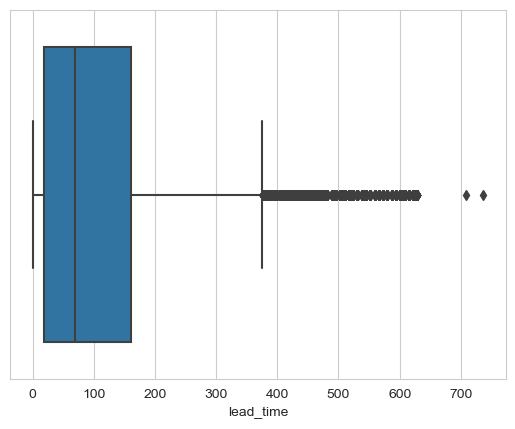

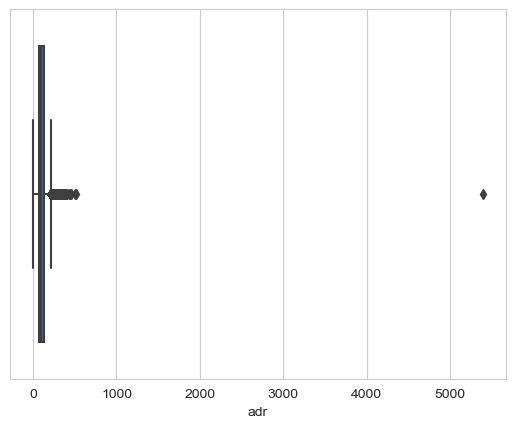

In [107]:
# LeadTime is result of subtraction of the entering date from the arrival date
sns.boxplot(data=data, x = 'lead_time')
plt.show()

# Average Daily Rate(adr) is result of dividing the sum of all lodging transactions by the total number of staying nights
sns.boxplot(data=data, x = 'adr')
plt.show()

In [108]:
# Interquartile Range of lead time
IQR_lt = data['lead_time'].quantile(0.75) -  data['lead_time'].quantile(0.25)
IQR_adr = data['adr'].quantile(0.75) -  data['adr'].quantile(0.25)
# Applying the 1.5 rule and remove the outliers
temp1 = data['lead_time'].quantile(0.75) + 1.5*IQR_lt
temp2 = data['adr'].quantile(0.75) + 1.5*IQR_adr
data_clean = data[data['lead_time'] <= temp1] 
data_clean = data_clean[data_clean['adr'] <= temp2] # new data with no outliers

## **Distribution of which country are the guest coming from**

In [109]:
dt_country = pd.DataFrame(data.loc[data['is_canceled'] != 1]['country'].value_counts())
dt_country.index.name = 'country'
dt_country.rename(columns={"country": "Number of Guests"}, inplace=True)
number_of_guests = dt_country["Number of Guests"].sum()
dt_country["Guests in %"] = round(dt_country["Number of Guests"] / number_of_guests * 100, 2)
dt_country.head(10)

,Number of Guests,Guests in %
country,,
PRT,20977,27.97
GBR,9668,12.89
FRA,8468,11.29
ESP,6383,8.51
DEU,6067,8.09
IRL,2542,3.39
ITA,2428,3.24
BEL,1868,2.49
NLD,1716,2.29


#### Based on the data shown above, most of the guest are coming from Portugal

In [110]:
# pip install plotly

In [148]:
import plotly.express as px
guest_map = px.choropleth(dt_country,
                    locations=dt_country.index,
                    color=dt_country["Guests in %"], 
                    hover_name=dt_country.index, 
                    title="Country of Origin of Guests")
guest_map.show()

## **Amount of guests based on hotels each year**

In [112]:
guest_data = data[data['is_canceled'] == 0].copy()
guests_monthly = guest_data[['hotel', 'arrival_date_year', 'arrival_date_month', 'adults', 'children', 'babies']].sort_values('arrival_date_year')
guests_monthly['total visitors'] = guests_monthly['adults'] + guests_monthly['children'] + guests_monthly['babies']
guests_monthly = guests_monthly.astype({'total visitors' : int})
guests_monthly = guests_monthly.drop(['adults', 'children', 'babies'], axis=1)
guests_monthly.head()

,hotel,arrival_date_year,arrival_date_month,total visitors
0,Resort Hotel,2015,July,2
43256,City Hotel,2015,September,2
43257,City Hotel,2015,September,2
43258,City Hotel,2015,September,2
43259,City Hotel,2015,September,2


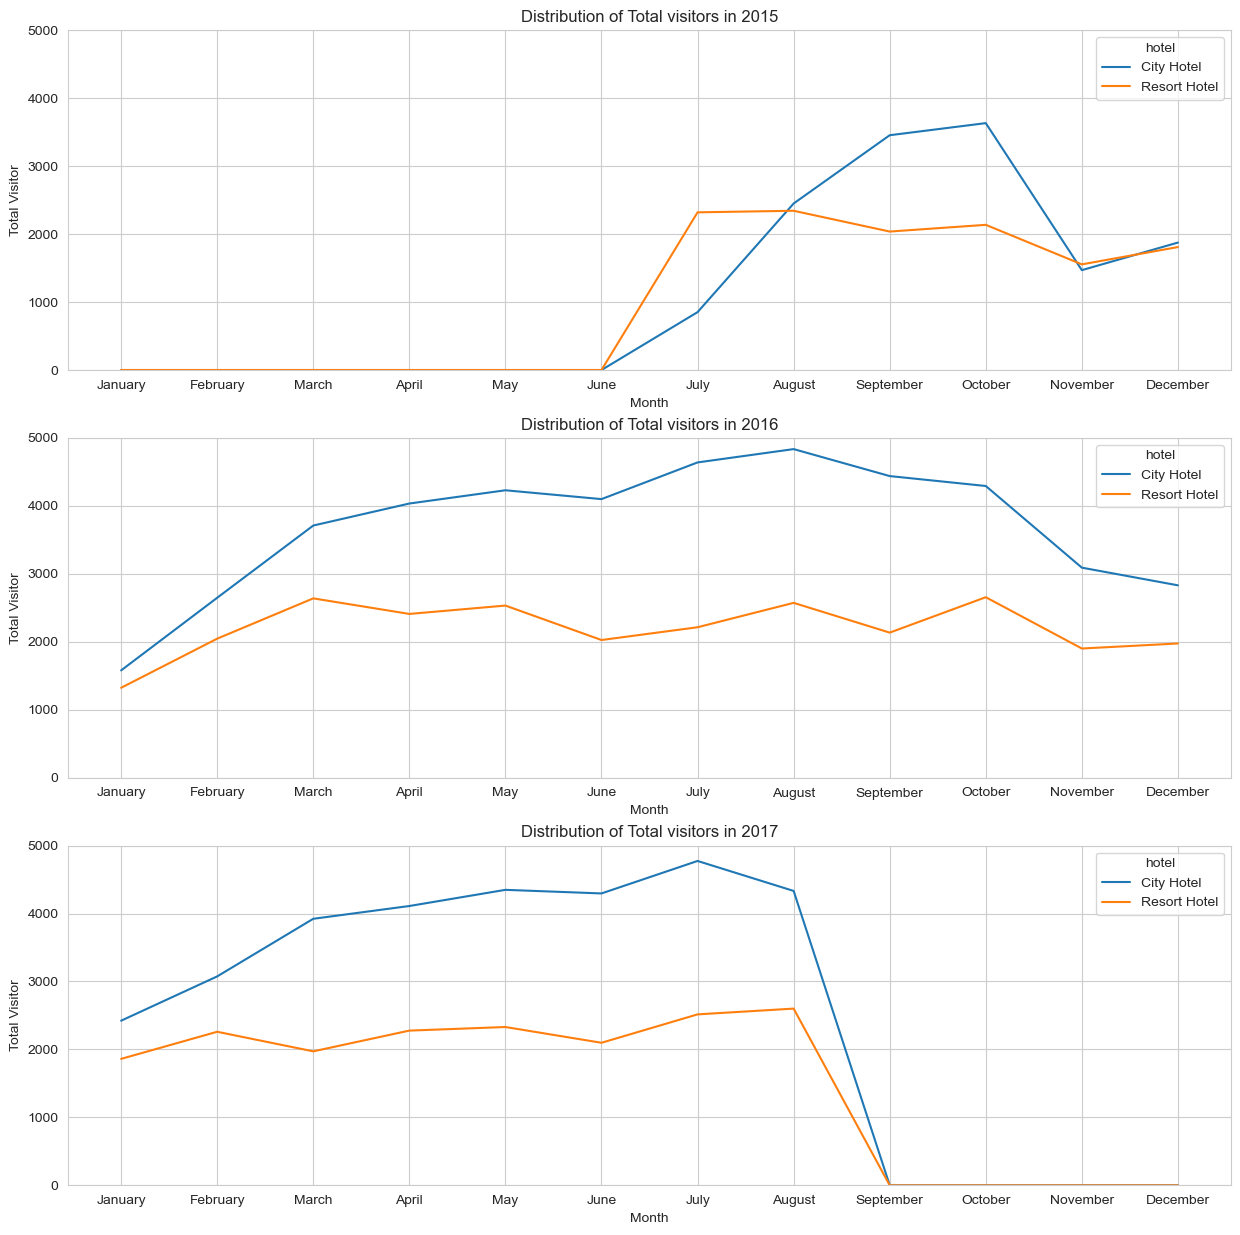

In [113]:
months_dict = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

guests_monthly['arrival_date_month'] = pd.Categorical(guests_monthly['arrival_date_month'], categories=months_dict, ordered=True)

guests_monthly = guests_monthly.groupby(['hotel', 'arrival_date_year', 'arrival_date_month'], as_index = False).sum()
f, ax = plt.subplots(3,1,figsize=(15,15))
sns.lineplot(x = 'arrival_date_month', y="total visitors", hue="hotel", data=guests_monthly[guests_monthly['arrival_date_year'] == 2015],  ci="sd", ax=ax[0])
sns.lineplot(x = 'arrival_date_month', y="total visitors", hue="hotel", data=guests_monthly[guests_monthly['arrival_date_year'] == 2016],  ci="sd", ax=ax[1])
sns.lineplot(x = 'arrival_date_month', y="total visitors", hue="hotel", data=guests_monthly[guests_monthly['arrival_date_year'] == 2017],  ci="sd", ax=ax[2])

ax[0].set(title="Distribution of Total visitors in 2015")
ax[0].set(xlabel="Month", ylabel="Total Visitor")
ax[0].set(ylim = (0,5000))

ax[1].set(title="Distribution of Total visitors in 2016")
ax[1].set(xlabel="Month", ylabel="Total Visitor")
ax[1].set(ylim = (0,5000))

ax[2].set(title="Distribution of Total visitors in 2017")
ax[2].set(xlabel="Month", ylabel="Total Visitor")
ax[2].set(ylim = (0,5000))

plt.show()

### The graphs above demonstrate that the distribution is not always as constant as what was predicted. The yearly pattern of increasing visitor numbers, which consistently takes place between June and August, has some commonalities. This could be attributed to families going on vacation in the middle of the school year and school breaks. More research might be done to determine the reasons behind the increase in visitors in some months. 

 



## **Total cost based on room type per night**

In [114]:
pd.options.mode.chained_assignment = None  # default='warn'
# Separate data based on room type
resort_hotel = data_clean[(data_clean['hotel'] == 'Resort Hotel') & (data_clean['is_canceled'] == 0)]
city_hotel = data_clean[(data_clean['hotel'] == 'City Hotel') & (data_clean['is_canceled'] == 0)]

resort_hotel['adr_pp'] = resort_hotel['adr'] / (resort_hotel['adults'] + resort_hotel['children'])
city_hotel['adr_pp'] = city_hotel['adr'] / (city_hotel['adults'] + city_hotel['children'])

### It is assumed that the curency used for transaction is Euro €, since most guest are from Portugal.

In [115]:
print(f"""
    Average price paid per person per night is:
    Resort Hotel: {resort_hotel['adr_pp'].mean():.2f} €
    City Hotel: {city_hotel['adr_pp'].mean():.2f} €""" 
    )


    Average price paid per person per night is:
    Resort Hotel: 44.50 €
    City Hotel: 58.82 €


In [116]:
raw_data_copy = data.copy()
raw_data_copy = raw_data_copy.loc[raw_data_copy['is_canceled'] == 0]
raw_data_copy['adr_pp'] = raw_data_copy['adr'] / (raw_data_copy['adults'] + raw_data_copy['children'])
room_prices = raw_data_copy[['hotel', 'reserved_room_type', 'adr_pp']].sort_values("reserved_room_type")

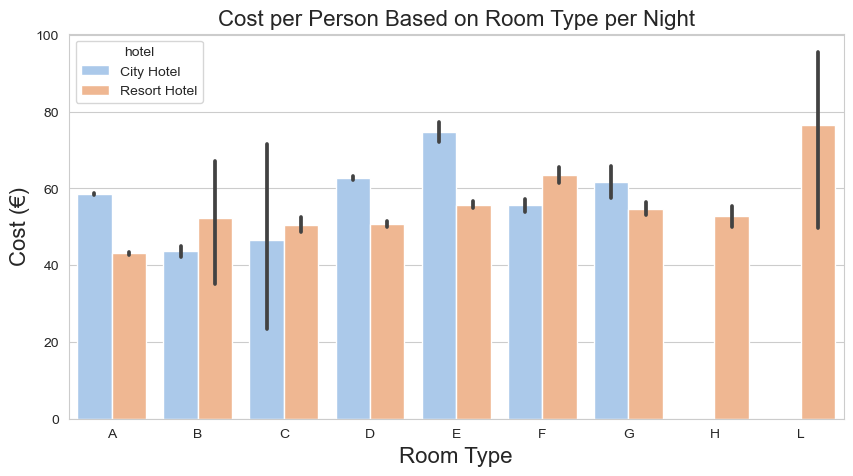

In [117]:
plt.figure(figsize=(10,5))
sns.barplot(x='reserved_room_type', y='adr_pp', hue='hotel', data=room_prices, hue_order=['City Hotel', 'Resort Hotel'], palette='pastel')
plt.title('Cost per Person Based on Room Type per Night', fontsize=16)
plt.xlabel('Room Type', fontsize = 16)
plt.ylabel('Cost (€)', fontsize = 16)
plt.show()

### The Resort Hotel has the most expensive Room Type, which is room L, as can be seen from the graph above. Except the City Hotel's room type E, which is significantly more expensive than the Resort Hotel's, the price difference between each room type is often not that considerable.

## **Most ordered Room Type**

In [118]:
print('Booking Frequency for each Room Type in City Hotel')
print(data[(data['hotel'] == 'City Hotel')]['reserved_room_type'].value_counts())
print('------------------------------------------------------------------')
print('Booking Frequency for each Room Type in Resort Hotel')
print(data[data['hotel'] == 'Resort Hotel']['reserved_room_type'].value_counts())

Booking Frequency for each Room Type in City Hotel
A    62484
D    11747
F     1788
E     1537
B     1112
G      482
C       13
Name: reserved_room_type, dtype: int64
------------------------------------------------------------------
Booking Frequency for each Room Type in Resort Hotel
A    23389
D     7432
E     4982
G     1610
F     1106
C      918
H      601
L        6
B        3
Name: reserved_room_type, dtype: int64


<AxesSubplot:xlabel='reserved_room_type', ylabel='count'>

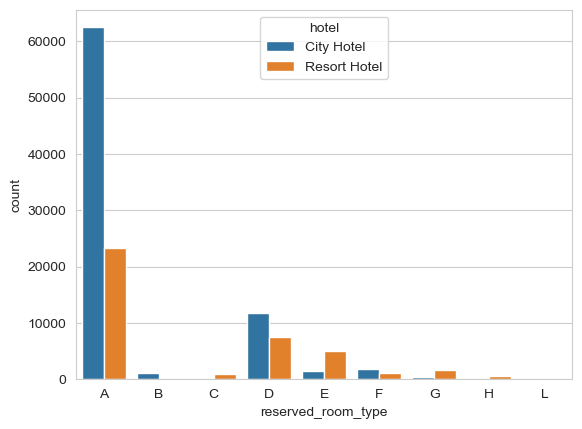

In [119]:
sns.countplot(x = 'reserved_room_type', data = data.sort_values('reserved_room_type'), hue='hotel') 

## **Market Segment Comparison based on Hotel**

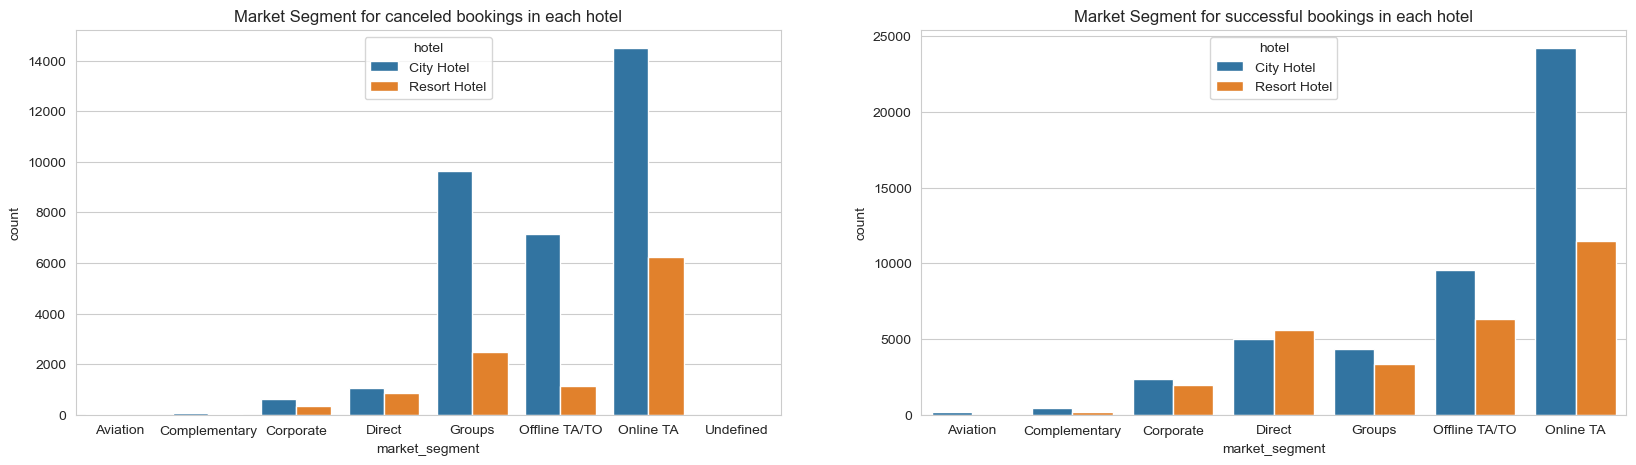

In [120]:
canceled = data[data['is_canceled'] == 1].sort_values('market_segment')
not_canceled = data[data['is_canceled'] == 0].sort_values('market_segment')
f, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data=canceled, x= 'market_segment', hue='hotel', ax =ax[0])
sns.countplot(data=not_canceled, x= 'market_segment', hue='hotel', ax =ax[1])
ax[0].set(title='Market Segment for canceled bookings in each hotel')
ax[1].set(title='Market Segment for successful bookings in each hotel')
plt.show()

### Based on this, it was determined that, regardless of the hotel, the majority of reservations were made via an online travel agency. This is due to how simple it is to purchase through these agents, who let customers reserve a room from anywhere. 

## **Investigating Correlation between all Features**

<AxesSubplot:>

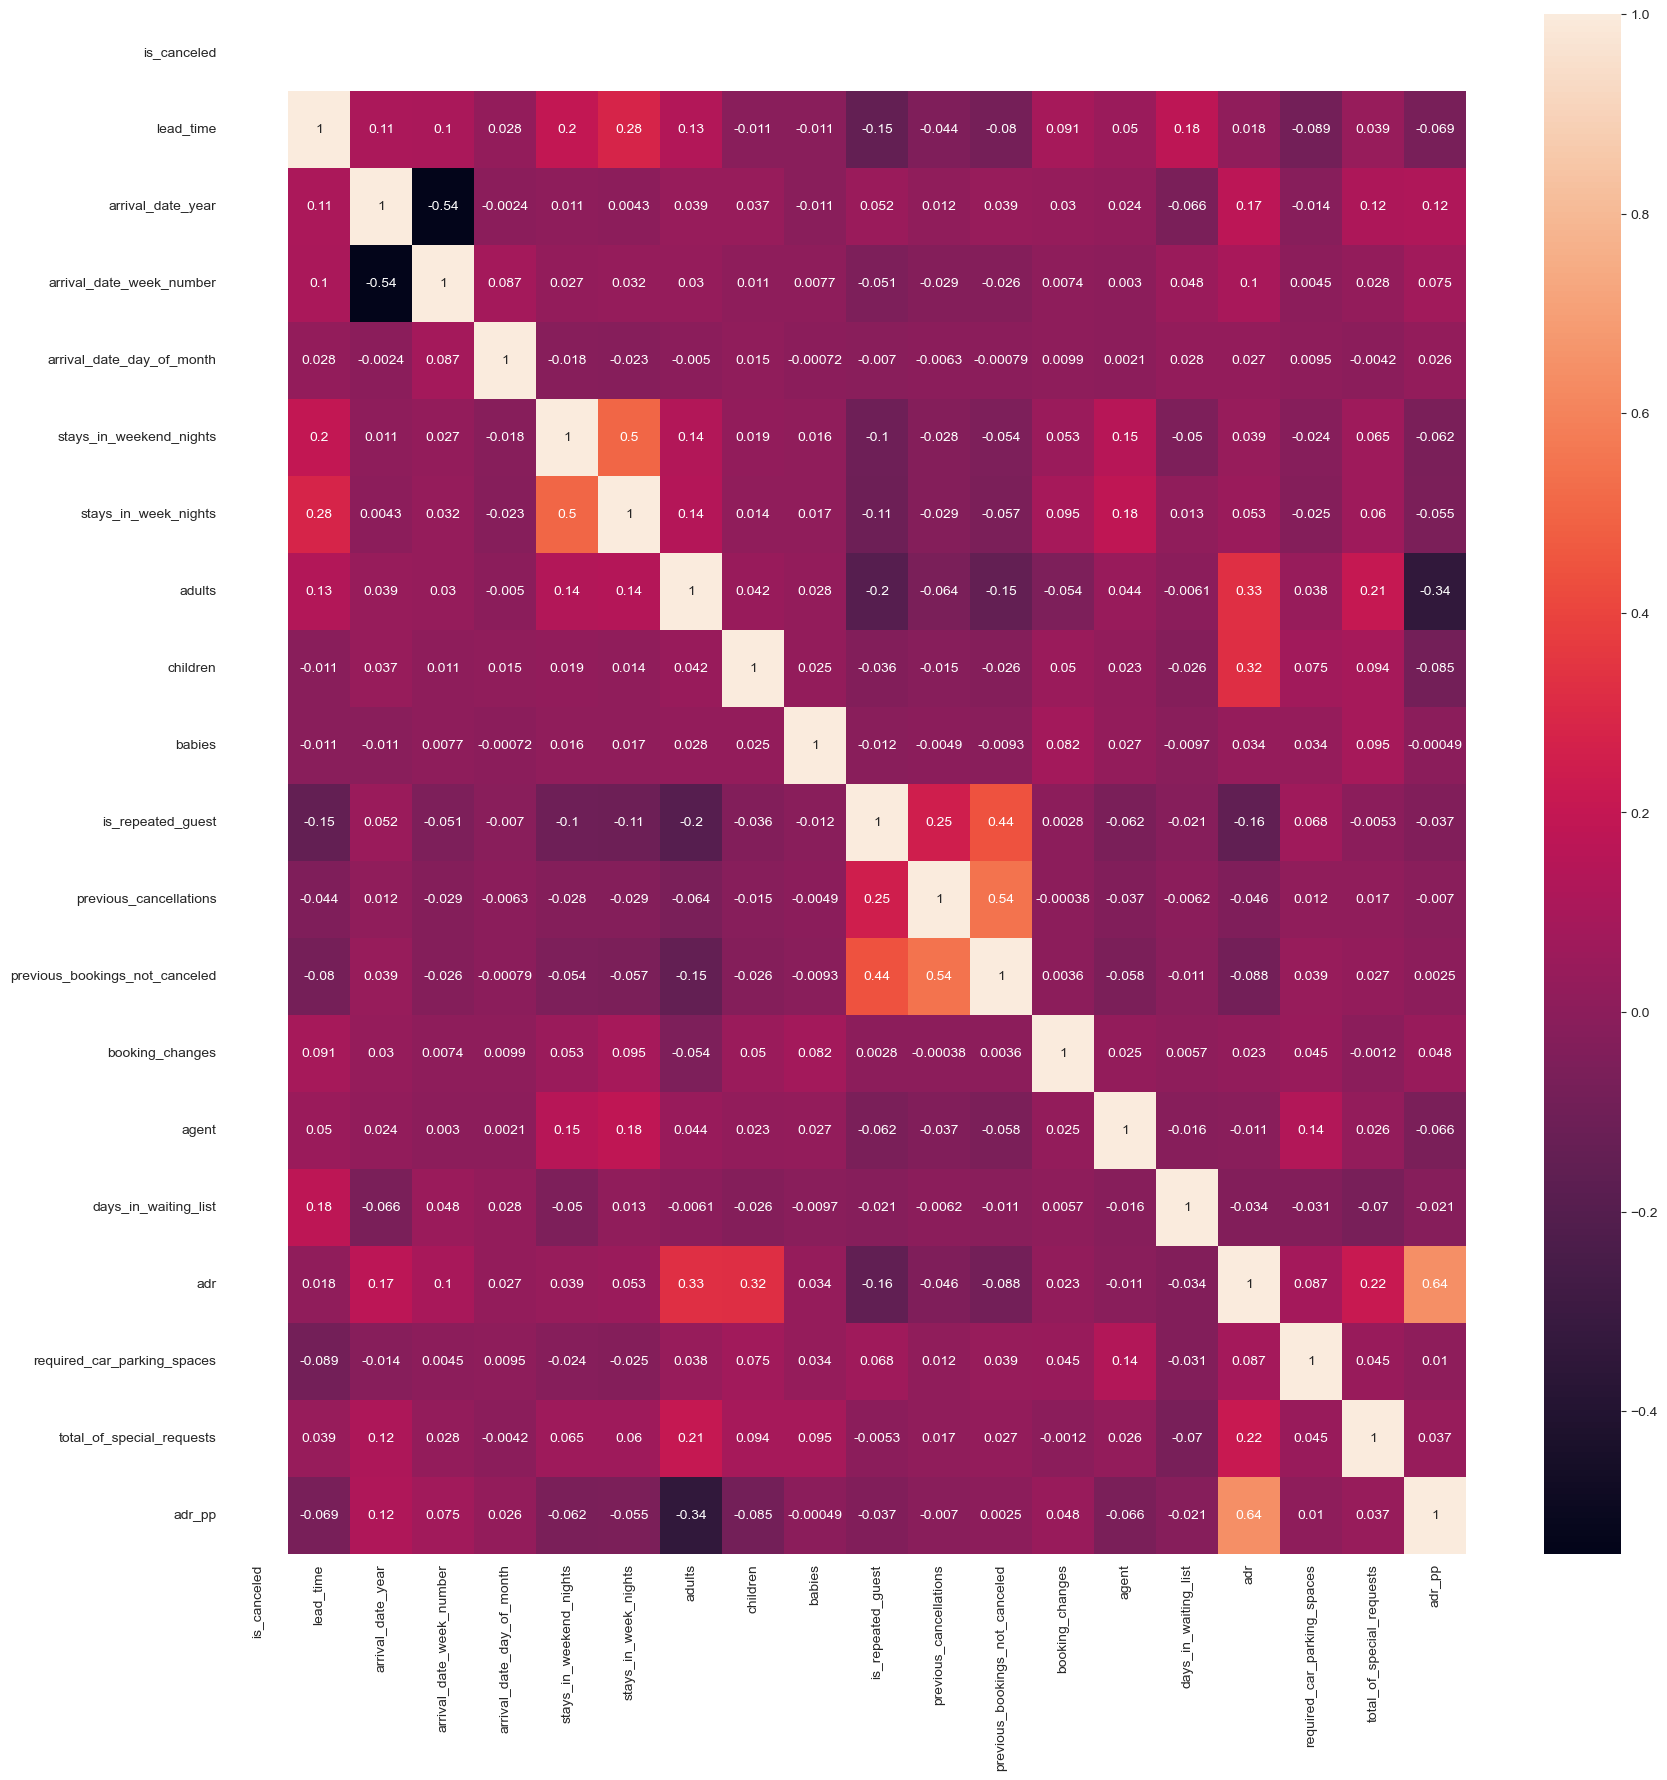

In [121]:
plt.figure(figsize=(20, 20))
sns.heatmap(raw_data_copy.corr(), annot=True)

## It was observed that there is a direct correlation between:
### 1. lead_time and is_cancelled
### Customers who make advanced reservations have a higher probability of having their reservations canceled. This might be brought about by carefully thought-out plans that must be changed as a result of unexpected circumstances. Natural calamities or unexpected diseases may also be other causes for cancellations.  
### 2. previous_bookings_not_cancelled and is_repeated
### Bookings that are made frequently are usually less likely to be canceled. This is due to the client's satisfaction with the hotel's services. A key conclusion from this is that there will be a larger likelihood of repeat reservations if the cancellation rate is decreased.

## **Observing amounts of adult guests with children** 

In [122]:
adult_no_child = data[(data['adults'] != 0) & (data['children'] == 0) & (data['babies'] == 0)].sort_values('reserved_room_type')   
adult_child = data[(data['adults'] != 0) & (data['children'] != 0) | (data['babies'] != 0)].sort_values('reserved_room_type')

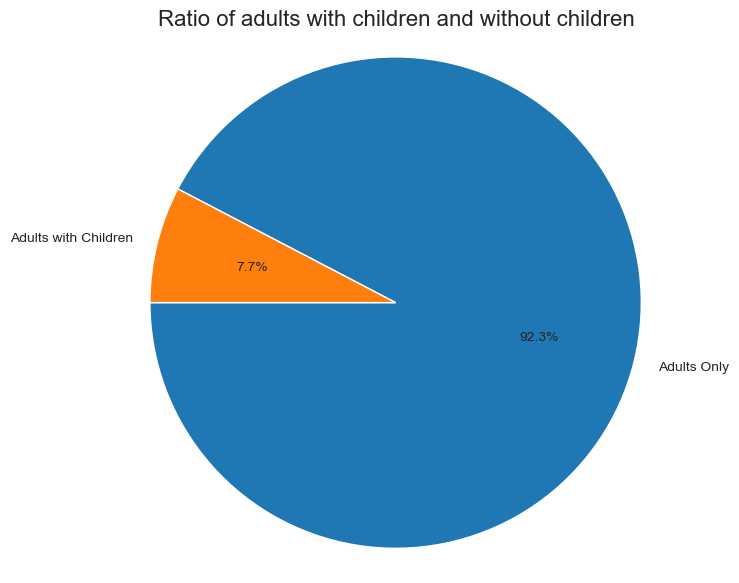

In [145]:
Ratios = [(len(adult_no_child)/(len(adult_no_child) + len(adult_child)))*100, (len(adult_child)/(len(adult_no_child) + len(adult_child)))*100]
labels = 'Adults Only', 'Adults with Children'

f, ax = plt.subplots(figsize=(7,7))
ax.pie(Ratios, labels = labels, autopct='%1.1f%%' , startangle = 180)
ax.axis('equal')

ax.set_title('Ratio of adults with children and without children', fontsize=16)
plt.show()

### Adults without children make the majority of the reservations. This can be an important insight because hotels often use adults as their target audience when marketing their services.

## **Total Cancellations in each months**

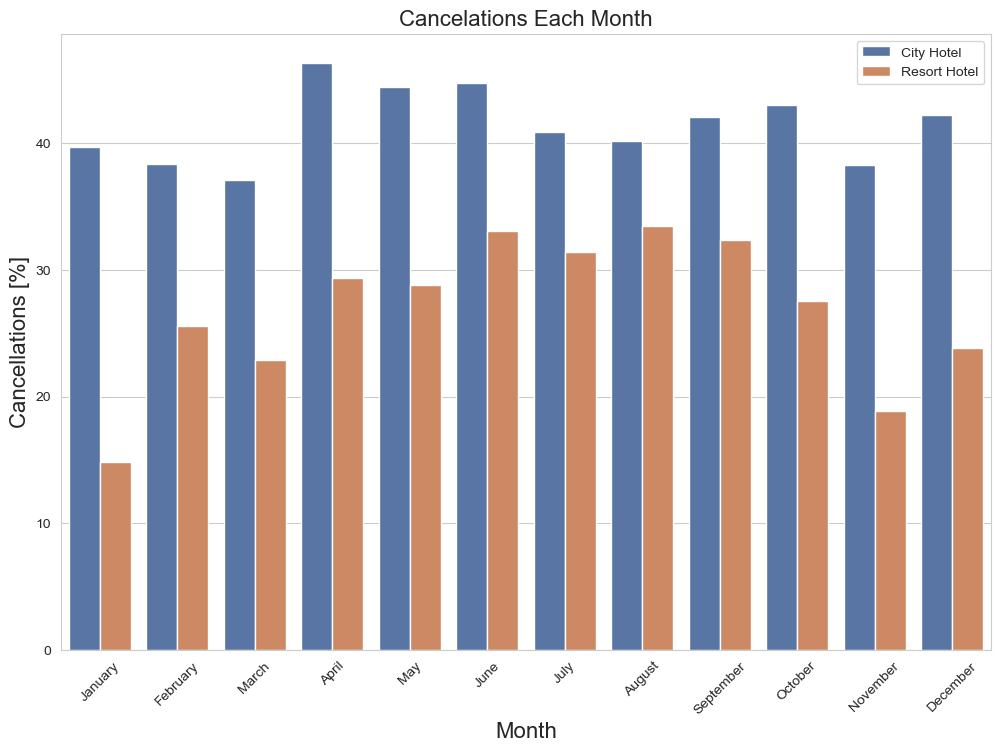

In [124]:
resort_bookings = data.loc[(data["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
resort_booking_canceled = data.loc[(data["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

city_hotel_bookings = data.loc[(data["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
city_hotel_canceled_booking = data.loc[(data["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(resort_bookings.index),
                                "Bookings": list(resort_bookings.values),
                                "Cancelations": list(resort_booking_canceled.values)})

cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(city_hotel_bookings.index),
                                "Bookings": list(city_hotel_bookings.values),
                                "Cancelations": list(city_hotel_canceled_booking.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data, palette = 'deep')
plt.title("Cancelations Each Month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancellations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

### This demonstrates that there is a more possibility of canceled reservations for City Hotel as 38% of total reservations are, on average, canceled. This is due to the nature of this hotel, which is often more affordable and makes it simpler for individuals to cancel their appointments as they won't lose that much money compared to booking a room at Resort Hotel.


## **Booking cancellations based on Market Segment**

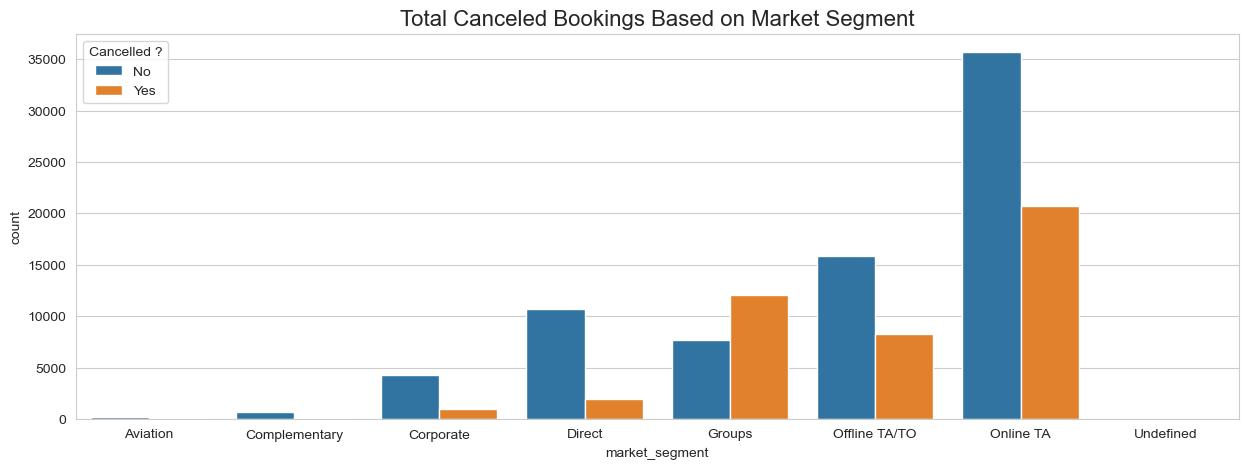

In [147]:
plt.figure(figsize=(15,5))
sns.countplot(x='market_segment', data=data.sort_values('market_segment'), hue = 'is_canceled')

plt.legend(title='Cancelled ?', loc='best', labels=['No', 'Yes'])
plt.title('Total Canceled Bookings Based on Market Segment', size = 16)
plt.show()

### The rate of cancellation for reservations made through an online travel agency is also high. As a result, even though they handle the majority of bookings, many of them are also canceled. This might also be a result of how simple it is to make and cancel reservations through an online travel agency. Online travel agencies frequently provide free cancellation costs as well. The high cancellation rate for reservations made through an online travel agency may be explained by both of these factors.
 

# **Machine Learning Modelling**

In [126]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier, plot_importance, DMatrix, train
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [127]:
train_data = pd.read_csv('C:\\Users\mubas\Downloads\hotel_bookings.csv')

In [128]:
empty_data = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
train_data = train_data.fillna(empty_data)
train_data["meal"].replace("Undefined", "SC", inplace=True)

In [129]:
train_data = train_data.drop(['company'],axis=1)
train_data = train_data.dropna(axis=0)

## **Label Encoding**

### Encoding each label with integers because it is easier to train the model with integers rather than strings.

In [130]:
train_data['hotel']=train_data['hotel'].map({'Resort Hotel':0,'City Hotel':1})
# arrival date
train_data['arrival_date_month'] = train_data['arrival_date_month'].map({'January':1,'February':2,'March':3,
                                                                'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10
                                                                ,'November':11,'December':12})


In [131]:
label_encoder = LabelEncoder()
train_data['meal']=label_encoder.fit_transform(train_data['meal'])
train_data['meal'].unique()

array([0, 1, 2, 3])

In [132]:
train_data['country']=label_encoder.fit_transform(train_data['country'])
train_data['market_segment']=label_encoder.fit_transform(train_data['market_segment'])
train_data['distribution_channel']=label_encoder.fit_transform(train_data['distribution_channel'])
train_data['reserved_room_type']=label_encoder.fit_transform(train_data['reserved_room_type'])
train_data['assigned_room_type']=label_encoder.fit_transform(train_data['assigned_room_type'])
train_data['deposit_type']=label_encoder.fit_transform(train_data['deposit_type'])
train_data['customer_type']=label_encoder.fit_transform(train_data['customer_type'])
train_data['reservation_status']=label_encoder.fit_transform(train_data['reservation_status'])
train_data['reservation_status_date']=label_encoder.fit_transform(train_data['reservation_status_date'])

In [133]:
train_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,0,342,2015,7,27,1,0,0,2,...,3,0,0.0,0,2,0.0,0,0,1,668
1,0,0,737,2015,7,27,1,0,0,2,...,4,0,0.0,0,2,0.0,0,0,1,668
2,0,0,7,2015,7,27,1,0,1,1,...,0,0,0.0,0,2,75.0,0,0,1,701
3,0,0,13,2015,7,27,1,0,1,1,...,0,0,304.0,0,2,75.0,0,0,1,701
4,0,0,14,2015,7,27,1,0,2,2,...,0,0,240.0,0,2,98.0,0,1,1,734


## **Feature Extraction**

In [134]:
# Gathering feature through correlation coefficient
correlation=train_data.corr()['is_canceled']
correlation.abs().sort_values(ascending=False)

is_canceled                       1.000000
reservation_status                0.917191
deposit_type                      0.468665
lead_time                         0.293177
country                           0.264709
total_of_special_requests         0.234706
required_car_parking_spaces       0.195492
assigned_room_type                0.176025
distribution_channel              0.167544
booking_changes                   0.144371
reservation_status_date           0.143258
hotel                             0.136505
previous_cancellations            0.110140
is_repeated_guest                 0.084788
customer_type                     0.068210
reserved_room_type                0.061284
adults                            0.059990
market_segment                    0.059314
previous_bookings_not_canceled    0.057355
days_in_waiting_list              0.054193
adr                               0.047622
agent                             0.046503
babies                            0.032488
stays_in_we

In [135]:
columns=['arrival_date_day_of_month','children',
     'arrival_date_week_number','stays_in_week_nights','reservation_status']
train_data=train_data.drop(columns,axis=1)
train_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,adults,babies,meal,country,...,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,0,0,342,2015,7,0,2,0,0,135,...,2,3,0,0.0,0,2,0.0,0,0,668
1,0,0,737,2015,7,0,2,0,0,135,...,2,4,0,0.0,0,2,0.0,0,0,668
2,0,0,7,2015,7,0,1,0,0,59,...,2,0,0,0.0,0,2,75.0,0,0,701
3,0,0,13,2015,7,0,1,0,0,59,...,0,0,0,304.0,0,2,75.0,0,0,701
4,0,0,14,2015,7,0,2,0,0,59,...,0,0,0,240.0,0,2,98.0,0,1,734


## **Building Model**

In [136]:
y=train_data['is_canceled'].values
x=train_data.drop(['is_canceled'],axis=1).values

In [137]:
# Split dataset
train_size = 0.9
test_size = 0.1
seed = 5

train_x,test_x,train_y,test_y=train_test_split(x,y,train_size=train_size,test_size=test_size,random_state=seed)

In [138]:
ensembles=[]
ensembles.append(('scaledRFC',Pipeline([('scale',StandardScaler()),('rf',RandomForestClassifier(n_estimators=10))])))

results=[]
names=[]
for name,model in ensembles:
    fold = KFold(n_splits=10,random_state=5,shuffle = True)
    result = cross_val_score(model,train_x,train_y,cv=fold,scoring='accuracy')
    results.append(result)
    names.append(name)
    msg="%s : %f (%f)"%(name,result.mean(),result.std())
    print(msg)

scaledRFC : 0.934107 (0.001862)


In [143]:
# Random Forest Classifier Tuning
from sklearn.model_selection import GridSearchCV

scaler=StandardScaler().fit(train_x)
rescaledx=scaler.transform(train_x)

n_estimators=[10,20,30,40,50]

param_grid=dict(n_estimators=n_estimators)

model=RandomForestClassifier()

fold=KFold(n_splits=10,random_state=0,shuffle=True)

grid=GridSearchCV(estimator=model,param_grid=param_grid,scoring='accuracy',cv=fold)
grid_result=grid.fit(rescaledx,train_y)

print("Best: %f using %s "%(grid_result.best_score_,grid_result.best_params_))

Best: 0.942195 using {'n_estimators': 50} 


## **Using Trained Model to Predict Outcomes**

In [140]:
from sklearn.metrics import confusion_matrix

scaler=StandardScaler().fit(train_x)
scaler_x=scaler.transform(train_x)
model=RandomForestClassifier(n_estimators=40)
model.fit(scaler_x,train_y)

#Transform the validation test set data
scaledx_test=scaler.transform(test_x)
pred_y=model.predict(scaledx_test)

accuracy_mean=accuracy_score(test_y,pred_y)
accuracy_matric=confusion_matrix(test_y,pred_y)
print(accuracy_mean)
print(accuracy_matric)

0.9453890610603903
[[7350  150]
 [ 502 3937]]


In [142]:
pred_y = model.predict(scaler.transform(x))
print(accuracy_score(y, pred_y))

0.9943125659625082


### The model were able to accurately predict the test data with an accuracy of 99.4%